# Library

In [ ]:
import pandas as pd
import numpy as np
from glob2 import glob
import json

import matplotlib as plt

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re

import gensim
import gensim.models.word2vec as w2v
from gensim.test.utils import common_texts
from datetime import datetime
from datetime import date
from datetime import timedelta

from nltk import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import emoji

import __Preprocessing


In [ ]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 400)
# pd.set_option('display.max_rowwidth', 100)
pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{}'.format
# pd.options.display.float_format = '{:.5f}'.format

# Functions

In [ ]:
# Deprecated
def getposcount_all_withPOScount(tokens):
    postag = []
    poscount = {}
    poscount['Noun']=0
    poscount['Verb']=0
    poscount['Adjective'] = 0
    poscount['Pronoun']=0
    poscount['FirstPersonPronoun']=0
    poscount['SecondPersonPronoun']=0
    poscount['ThirdPersonPronoun']=0
    poscount['Adverb']=0
    poscount['Numeral']=0
    poscount['Conjunction_inj']=0
    poscount['Particle']=0
    poscount['Determiner']=0
    poscount['Modal']=0
    poscount['Whs']=0
    poscount['test_auxiliary']=0
    poscount['test_tentat']=0
    poscount['test_certain']=0

    Nouns = {'NN','NNS','NNP','NNPS'}
    Adverbs = {'RB','RBR','RBS'}
    Whs = {'WDT','WP','WRB'} # Composition of wh-determiner(that,what), wh-pronoun(who), wh-adverb(how)
    Verbs={'VB','VBP','VBZ','VBN','VBG','VBD','To'}
    first_person_pronouns=['i','me','my','mine','we','us','our','ours'] #'i',
    second_person_pronouns=['you','your','yours', 'ya']
    third_person_pronouns=['he','she','it','him','her','it','his','hers','its','they','them','their','theirs']
    test_auxiliary=['be','will','have','am','is','was','were','can','could','dare','did','may','might','must','ought','shall','should','would']
    test_tentat=['maybe','perhaps','possibly','probably','guess']
    test_certain=['always','never']

    for word in tokens:
        w_lower=word.lower()
        if w_lower in first_person_pronouns:
            poscount['FirstPersonPronoun']+=1
        elif w_lower in second_person_pronouns:
            poscount['SecondPersonPronoun']+=1
        elif w_lower in third_person_pronouns:
            poscount['ThirdPersonPronoun']+=1
        
    for word in tokens:
        w_lower=word.lower()
        if w_lower in test_auxiliary:
            poscount['test_auxiliary']+=1
        elif w_lower in test_tentat:
            poscount['test_tentat']+=1
        elif w_lower in test_certain:
            poscount['test_certain']+=1
    
    postag = nltk.pos_tag(tokens)
    for g1 in postag:
        if g1[1] in Nouns:
            poscount['Noun'] += 1
        elif g1[1] in Verbs:
            poscount['Verb']+= 1
        elif g1[1]=='ADJ'or g1[1]=='JJ':
            poscount['Adjective']+=1
        elif g1[1]=='PRP' or g1[1]=='PRON' or g1[1]=='PRP$':
            poscount['Pronoun']+=1
        elif g1[1] in Adverbs or g1[1]=='ADV':
            poscount['Adverb']+=1
        elif g1[1]=='CD':
            poscount['Numeral']+=1
        elif g1[1]=='CC' or g1[1]=='IN':
            poscount['Conjunction_inj']+=1
        elif g1[1]=='RP':
            poscount['Particle']+=1
        elif g1[1]=='MD':
            poscount['Modal']+=1
        elif g1[1]=='DT':
            poscount['Determiner']+=1
        elif g1[1] in Whs:
            poscount['Whs']+=1
    return poscount

In [ ]:
lmt = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
freqdist = nltk.FreqDist()
stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer()

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not'), 
                         (r'i\'d', 'i would'), (r'I\'d', 'I would'), (r'he\'d', 'he would'), (r'she\'d', 'she would'), (r'they\'d', 'they would'), (r'we\'d', 'we would')]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def capitalratio(tweet_text):
    uppers = [l for l in tweet_text if l.isupper()]
    capitalratio = len(uppers) / len(tweet_text)
    return capitalratio 

def getTokenization(sent):
    tweet_tokens = []
    sent = sent.lower()
    sent = replaceContraction(sent)

    sent = re.sub(r"http\S+", "*", sent) # http link -> '*'
    # sent = re.sub(r"@\S+", "@", sent)   # mention -> '@'
    sent = re.sub(r"@[^\s]+", "@", sent)   # mention -> '@'
    sent = re.sub(r"(#)(\S+)", r'\1 \2', sent) 

    sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters
    # sent = re.sub('@[^\s]+','atUser',sent)
    # sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',sent)
    # sent = re.sub(r'#([^\s]+)', r'\1', sent)


    # sent = re.sub('', '', sent.lower())
    # sent = [tweet_tokenizer.tokenize(sent)]
    sent = tweet_tokenizer.tokenize(sent)
    sent = [stemmer.stem(token) for token in sent]
    sent = [lmt.lemmatize(token) for token in sent]

    temp = [token for token in sent if not token in stop_words]
    url=0
    for token in temp:
        if token.startswith('*'):
            url+=1
    # tweet_tokens.append([temp])
    # tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    # df_tokens = pd.DataFrame(tweet_tokens, columns=['token'])
    return temp, url

def extract_urls(entities_dicts):
    if len(entities_dicts) < 1:
        return 0
    if len(entities_dicts) == 1:
        return 1
    if len(entities_dicts) == 2:
        return 2

    # urls = []
    # urls_expanded = []

    # key = 'url'
    # key2 = 'expanded_url'
    # # print(len(entities_dict))
    # for i in entities_dicts:
    #     urls.append(i[key])
    #     urls_expanded.append(i[key2])
    # return 1, urls, urls_expanded


In [ ]:

def getposcount_all(tokens):
    postag = []
    poscount = {}

    poscount['FirstPersonPronoun']=0
    poscount['SecondPersonPronoun']=0
    poscount['ThirdPersonPronoun']=0
    poscount['test_auxiliary']=0
    poscount['test_tentat']=0
    poscount['test_certain']=0
    poscount['Numeral']=0


    first_person_pronouns=['i','me','my','mine','we','us','our','ours'] #'i',
    second_person_pronouns=['you','your','yours', 'ya']
    third_person_pronouns=['he','she','it','him','her','it','his','hers','its','they','them','their','theirs']
    test_auxiliary=['be','will','have','am','is','was','were','can','could','dare','did','may','might','must','ought','shall','should','would']
    test_tentat=['maybe','perhaps','possibly','probably','guess']
    test_certain=['always','never']

    for word in tokens:
        w_lower=word.lower()
        if w_lower in first_person_pronouns:
            poscount['FirstPersonPronoun']+=1
        elif w_lower in second_person_pronouns:
            poscount['SecondPersonPronoun']+=1
        elif w_lower in third_person_pronouns:
            poscount['ThirdPersonPronoun']+=1
        
    for word in tokens:
        w_lower=word.lower()
        if w_lower in test_auxiliary:
            poscount['test_auxiliary']+=1
        elif w_lower in test_tentat:
            poscount['test_tentat']+=1
        elif w_lower in test_certain:
            poscount['test_certain']+=1

    postag = nltk.pos_tag(tokens)
    for g1 in postag:
        if g1[1]=='CD':
            poscount['Numeral']+=1
    return poscount

def fetchRawText_all(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/[0-9]*.json' % (path, event, tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))

    targets = []
    features = []
    isSrcTweet = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)
            if jsonFile.find("source-tweet") == -1:
                isSrcTweet.append(0)
            else: #if jsonFile.find("reactions") == 1:
                isSrcTweet.append(1)
                

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    json_data = json.loads(l)
                    dataEvent.append(json_data)
        targets.append(targetEvent)
        features.append(dataEvent)
        # isSrcTweet.append(isSrcTweet)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])
    isSrcTweet = pd.DataFrame(isSrcTweet, columns=["isSrcTweet"])

    extracted_features = []

    extracted = []

    NoneList = []

    for obj_list in features:
        extracted_event = []
        for obj in obj_list:
            output_f = dict()

            if (('id' not in obj)):
                print('sth happend')
                return obj

            if ('text' in obj):
                output_f['text'] = obj['text']
            else:
                output_f['text'] = None
            if ('text' in obj):
                output_f['text'] = obj['text']
            else:
                output_f['text'] = None
            if ('id' in obj):
                output_f['id'] = obj['id']
            else:
                output_f['id'] = None
            if ('in_reply_to_status_id' in obj):
                output_f['pid'] = obj['in_reply_to_status_id']
            else:
                output_f['pid'] = None
            output_f['userid'] = obj['user']['id']
            
            output_f['emoji_count'] = emoji.emoji_count(obj['text'])
            urls_dicts = obj['entities']['urls']
            if "media" in obj['entities']:
                output_f['has_media'] = len(obj['entities']['media'])
                # output_f['media_type'] = obj['entities']['media'][0]['type']
            else:
                output_f['has_media'] = 0
                # output_f['media_type'] = 0
            output_f['URLcount'] = len(urls_dicts)
            # output_f['URLcount'] = extract_urls(urls_dicts)
            # temp = obj['text'].lower()
            # temp = re.sub(r"http\S+", "HTTPURL", obj['text'])
            verification = 0
            verification += len(re.findall(r'is(that|this|it) true', obj['text']))
            verification += len(re.findall(r'wh[a]*t[?!|!?][?!|!?]*', obj['text']))
            verification += len(re.findall(r'(rumour|rumor|debunk)', obj['text']))
            verification += len(re.findall(r'(real?|really?|uncomfirmed)', obj['text']))
            verification += len(re.findall(r'(that|this|it) is not true', obj['text']))
            verification += len(re.findall(r'(that|this|it) is false', obj['text']))
            verification += len(re.findall(r'(h[m]*)', obj['text']))
            output_f['Skepticism'] = verification            

            '''POS Tagging'''
            temp = output_f['text']
            temp = replaceContraction(temp.lower())
            temp = re.sub(r"(#)(\S+)", '', temp)
            temp = re.sub(r"(@)(\S+)", '', temp)
            temp = re.sub(r"http\S+", "", temp)
            temp = re.sub(r'([^\s\w#\*]|_)+', '', temp) # Erasing Special Characters
            temp = temp.split()
            pos_dict=getposcount_all(temp)

            output_f['token_for_POS'] = temp
            output_f.update(pos_dict)

            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            # output_f['HashTag'] = len(obj['entities'][0]['hashtags'])
            output_f['HashTag'] = len(obj['entities']['hashtags'])

            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['retweet_count'] = obj['retweet_count']
            output_f['isRT'] = obj['retweeted']

            # output_f['statuses_count'] = np.log10(obj['user']['statuses_count']+0.0000000001)
            # output_f['listed_count'] = np.log10(obj['user']['listed_count']+0.000000001)
            # output_f['friends_count'] = np.log10(obj['user']['friends_count']+0.0000000001)
            # output_f['followers_count'] = np.log10(obj['user']['followers_count']+0.0000000001)

            output_f['statuses_count'] = obj['user']['statuses_count']
            output_f['listed_count'] = obj['user']['listed_count']
            output_f['friends_count'] = obj['user']['friends_count']
            output_f['followers_count'] = obj['user']['followers_count']

            output_f['location'] = obj['user']['location']
            output_f['name'] = obj['user']['name']

            if (output_f['friends_count'] <= 0):
                output_f['followers/friend'] = obj['user']['followers_count']
            else:
                output_f['followers/friend'] = obj['user']['followers_count']/obj['user']['friends_count']

            output_f['favourites_count'] = obj['user']['favourites_count']
            
            acc_created = datetime.strptime(obj['user']['created_at'], '%a %b %d %H:%M:%S %z %Y')
            tweet_created = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
            age = (tweet_created - acc_created)
            output_f['account_age_days'] = age.days
            output_f['tweet_created'] = datetime.timestamp(tweet_created)
            # output_f['tweet_created2'] = tweet_created

            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['verified'] = obj['user']['verified']

            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    # print(events)
    # print(len(extracted_features))
    for i, data in enumerate(extracted_features):
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, isSrcTweet ,target], axis=1)
    final.pid = final.pid
    return final

def depth(x):
    if type(x) is dict and x:
        return 1 + max(depth(x[a]) for a in x)
    if type(x) is list and x:
        return 1 + max(depth(a) for a in x)
    return 0

def getThreadData(path, events):
    import re

    sources = []
    for i, event in enumerate(events):
        sources.append(glob('%s/%s/*/*' % (path, event)))
    roots = []
    children = []
    features = []
    isSrcTweet = []
    for num, event in enumerate(sources):
        for index, dataset in enumerate(event):
            # print(dataset)
            # children.append(glob('%s/reactions/*/*' % (dataset)))
            childs = [os.path.basename(x) for x in glob('%s/reactions/*.json' % (dataset))]
            reext = re.compile(r'(.*?)\.json')
            childs = (reext.match(child) for child in childs)
            children.append([match.group(1) for match in childs if match])
            # print(dataset)
            roots.append(os.path.basename(dataset))

    df = pd.DataFrame(roots, columns=['Root'])
    df = pd.concat([df,pd.DataFrame(children)],axis=1)
    
    structfile = []
    annotatedfile= []
    for i, event in enumerate(events):
        structfile.append(glob('%s/%s/**/[0-9]*/structure.json' % (path, event)))
        annotatedfile.append(glob('%s/%s/**/[0-9]*/annotation.json' % (path, event)))

    for i,d in enumerate(structfile): print("%s's structure.json number is %d" %(events[i], len(d)))
    for i,d in enumerate(annotatedfile): print("%s's annotated.json number is %d" %(events[i], len(d)))
    # print(structfile)

    thread_depths = []
    thread_roots = []
    for index, dataset in enumerate(structfile):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            # print(jsonFile)
            match = re.search("/([0-9]*)/", jsonFile)
            rootname = match.group(1) if match else None
            # print(rootname)
            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                json_data = json.loads(l)
                # print(json_data)
                thread_depth = depth(json_data)
                thread_depths.append([rootname,thread_depth])
                # thread_roots.append(rootname)
    df_depth = pd.DataFrame(thread_depths, columns=['Root', 'depth'])
    df = pd.merge(df, df_depth, on="Root")
    
    isTrue = []
    misinfo = []
    for index, dataset in enumerate(annotatedfile):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            match = re.search("/([0-9]*)/", jsonFile)
            rootname = match.group(1) if match else None
            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                json_data = json.loads(l)
                if ('misinformation' in json_data ):
                    misinformation = json_data['misinformation']
                else:
                    misinformation = -1
                if (json_data['is_rumour'] == "nonrumour"):
                    truth = 0
                elif (json_data['is_rumour'] == "rumour" and 'true' in json_data):
                    if (json_data['true']==1):
                        truth = 1
                    elif (json_data['true']==0):
                        truth = 2
                else:
                    truth = -1
                misinfo.append([rootname,misinformation,truth])
                # print(json_data)
                # print(json_data)
                # misinfo = json_data['misinformation']
                # misinfo.append([rootname,json_data['misinformation']])
                # thread_roots.append(rootname)
    df_annotation = pd.DataFrame(misinfo,columns=['Root', 'misinformation', 'truth'])
                
    # return pd.DataFrame(thread_depths)
    return df , df_annotation

def getThreadDataPHEME(path, events):
    import re

    sources = []
    for i, event in enumerate(events):
        sources.append(glob('%s/%s/*/*' % (path, event)))
    roots = []
    children = []
    features = []
    isSrcTweet = []
    childs_list=[]
    for num, event in enumerate(sources):
        for index, dataset in enumerate(event):
            # print(dataset)
            # children.append(glob('%s/reactions/*/*' % (dataset)))
            childs = [os.path.basename(x) for x in glob('%s/reactions/*.json' % (dataset))]
            reext = re.compile(r'(.*?)\.json')
            childs = (reext.match(child) for child in childs)
            children.append([match.group(1) for match in childs if match])
            # print(dataset)
            roots.append(os.path.basename(dataset))

            # childs_list.append(children)

    df = pd.DataFrame(roots, columns=['Root'])
    return pd.concat([df,pd.DataFrame(children)],axis=1)
    return df
    
    structfile = []
    for i, event in enumerate(events):
        structfile.append(glob('%s/%s/**/[0-9]*/structure.json' % (path, event)))

    for i,d in enumerate(structfile): print("%s's structure.json number is %d" %(events[i], len(d)))
    # print(structfile)

    thread_depths = []
    thread_roots = []
    for index, dataset in enumerate(structfile):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            # print(jsonFile)
            match = re.search("/([0-9]*)/", jsonFile)
            # p.match("lalalaI want this partlalala").group(1)
            rootname = match.group(1) if match else None
            # print(rootname)
            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                json_data = json.loads(l)
                # print(json_data)
                thread_depth = depth(json_data)
                thread_depths.append([rootname,thread_depth])
                # thread_roots.append(rootname)
    df_depth = pd.DataFrame(thread_depths, columns=['Root', 'depth'])
    df = pd.merge(df, df_depth, on="Root")
                
    
    # return pd.DataFrame(thread_depths)
    return df

In [ ]:
import warnings
warnings.filterwarnings("ignore")
'''
@POStag-related: hashtag url mention emoji FPP SPP TPP

'''

def getThreadInfo_AVG(structure, df):

    threadInfo = []
    thread_depth = structure[['Root', 'depth']]
    structure = structure.drop('depth', axis=1)
    for index, data in enumerate(structure.Root):
        tweetInfo = []
        # print("data: %s\n" %(data))
        # print("data: %s\n%s\n" %(data, structure.loc[index,0:].values))
        # print("root: %s\tFirst reaction: %s\n" %(data, structure.loc[index,0]))

        pid = int(data)
        thread = structure.loc[structure['Root']==pid].dropna(axis=1)
        thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 

        # threadRange = structure.loc[structure['Root']==data].any().sum()-1
        # print(structure)
        threadRange = len(structure.iloc[index,:].dropna())

        # 아래로는 성공적인 Features
        friends_sum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        friends_avg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        
        words_sum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])
        words_avg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])

        char_avg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['char_count'].values) for childid in structure.loc[index,:].dropna()])
        
        hashtagsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['HashTag']) for childid in structure.loc[index,:].dropna()])
        
        urlsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        # urlavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        
        mentionsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        
        statuesavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['statuses_count'].values) for childid in structure.loc[index,:].dropna()])
        
        listedavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['listed_count'].values) for childid in structure.loc[index,:].dropna()])

        followeravg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['followers_count'].values) for childid in structure.loc[index,:].dropna()])

        followers_friendratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['followers/friend'].values) for childid in structure.loc[index,:].dropna()])

        favoriteavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['favourites_count'].values) for childid in structure.loc[index,:].dropna()])
        
        verifiedsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        verifiedratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])

        retweetsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        # retweetstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])

        accageavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])
        # accagestd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])

        emojiavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        emojiratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        # emojistd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])

        mediaratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_media'].values) for childid in structure.loc[index,:].dropna()])
        questionratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_question'].values) for childid in structure.loc[index,:].dropna()])
        exclamationratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_exclaim'].values) for childid in structure.loc[index,:].dropna()])
        periodratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_period'].values) for childid in structure.loc[index,:].dropna()])

        FPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        # FPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        # SPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        # TPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])

        Skepticismmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])
        Skepticismratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])

        test_auxiliaryratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['test_auxiliary'].values) for childid in structure.loc[index,:].dropna()])
        test_tentatratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['test_tentat'].values) for childid in structure.loc[index,:].dropna()])
        test_certainratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['test_certain'].values) for childid in structure.loc[index,:].dropna()])

        # 루트 트윗 작성자가 쓰레드에서 차지하는 비율
        root_user_ratio = np.sum([np.any(all_ext.loc[(all_ext['id'] == int(childid)) & (all_ext['userid'] == p_userid)]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]) / thread_node_count
        unique_user_ratio = len(np.unique([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['userid'].values) for childid in structure_ext.loc[0, :].dropna()])) / thread_node_count
        unique_user_sum = len(np.unique([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]))

        # Get the lifetime of thread
        # root_created = df.loc[(df['id'] == int(pid))].tweet_created.sum()
        # try:
        #     thread_latest = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created'].values) for childid in structure.loc[index,'0':].dropna()])
        # except:
        # #     print([df.loc[(df['id'] == int(childid))]['tweet_created'].values for childid in structure.loc[index,'0':].dropna()])
        #     print("error")

        # thread_life = thread_latest - root_created
        try:
            thread_life = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - df.loc[(df['id'] == pid)].tweet_created.sum())
            # if thread_life < 0: thread_life=0
        except:
            print("index:", index)

        # 해당 스레드의 트윗 개수
        # print("thread_node_count:",thread_node_count,", threadRange:",threadRange, "lastest Thread:", thread_latest )
        # print(structure.loc[structure.Root == data])

        tweetInfo.append(data)
        # friends_sum = np.log(friends_sum, where=0<friends_sum, out=np.nan*friends_sum)
        # friends_sum = np.log10(friends_sum-friends_sum.min()+1)
        tweetInfo.append(friends_sum)
        tweetInfo.append(friends_avg)
        tweetInfo.append(words_avg)
        tweetInfo.append(words_sum)
        tweetInfo.append(char_avg)

        tweetInfo.append(hashtagavg)
        tweetInfo.append(hashtagsum)
        tweetInfo.append(hashtagratio)
        tweetInfo.append(urlsum)
        tweetInfo.append(urlavg)
        # tweetInfo.append(urlstd)
        tweetInfo.append(urlratio)
        tweetInfo.append(mentionsum)
        tweetInfo.append(mentionavg)
        tweetInfo.append(mentionratio)
        tweetInfo.append(statuesavg)
        tweetInfo.append(listedavg)
        tweetInfo.append(followeravg)
        tweetInfo.append(followers_friendratio)
        tweetInfo.append(favoriteavg)
         
        tweetInfo.append(thread_node_count)
        tweetInfo.append(verifiedratio)
        tweetInfo.append(verifiedsum)
        tweetInfo.append(retweetsum)
        tweetInfo.append(retweetavg)
        # tweetInfo.append(retweetstd)
        tweetInfo.append(accageavg)
        # tweetInfo.append(accagestd)
        tweetInfo.append(thread_life)
        # tweetInfo.append(emojistd)
        tweetInfo.append(emojiavg)
        tweetInfo.append(emojiratio)
        tweetInfo.append(mediaratio)
        tweetInfo.append(questionratio)
        tweetInfo.append(exclamationratio)
        tweetInfo.append(periodratio)
        tweetInfo.append(FPPmean)
        # tweetInfo.append(FPPstd)
        tweetInfo.append(SPPmean)
        # tweetInfo.append(SPPstd)
        tweetInfo.append(TPPmean)
        # tweetInfo.append(TPPstd)
        tweetInfo.append(Skepticismmean)
        tweetInfo.append(Skepticismratio)
        tweetInfo.append(test_auxiliaryratio)
        tweetInfo.append(test_tentatratio)
        tweetInfo.append(test_certainratio)
        tweetInfo.append(root_user_ratio)
        tweetInfo.append(unique_user_ratio)
        tweetInfo.append(unique_user_sum)

        threadInfo.append(tweetInfo)

        result = pd.DataFrame(threadInfo, columns=['Root', 'SUM FriendsCount','AVG FriendsCount', 'AVG WordCount','SUM WordCount', 'AVG CharCount', 'AVG HashTag', 'SUM HashTag', 'Ratio HashTag','SUM Url', 'AVG Url','RATIO Url','SUM Mention', 'AVG Mention', 'Ratio Mention','AVG Statues','AVG Listed','AVG Follower','AVG followers/friend','AVG favorite', 'Tweets Count', 'Ratio Verified','SUM Verified','SUM RT', 'AVG RT','AVG AccAge', 'thread_time', "AVG Emoji","RATIO Emoji","Ratio Media",'RATIO Question', 'RATIO Exclaim','RATIO Period', 'AVG FPP', 'AVG SPP','AVG TPP','AVG Skepticism','Ratio Skepticism', 'test_auxiliary','test_tentat','test_certain', 'root_user_ratio','unique_user_ratio','unique_user_sum'])
        result = pd.merge(thread_depth, result, on="Root").drop(['Root'], axis=1)
    # result.friends_sum = np.log10(result.friends_sum-result.friends_sum.min()+1)
    # result.friends_avg = np.log10(result.friends_avg-result.friends_avg.min()+1)

    # print(threadInfo)
    # result['SUM FriendsCount'] = np.log10(result['SUM FriendsCount']-result['SUM FriendsCount'].min()+1)
    # result['AVG FriendsCount'] = np.log10(result['AVG FriendsCount']-result['AVG FriendsCount'].min()+1)
    # result['AVG Statues'] = np.log10(result['AVG Statues']-result['AVG Statues'].min()+1)
    # result['AVG Listed'] = np.log10(result['AVG Listed']-result['AVG Listed'].min()+1)
    # result['AVG Follower'] = np.log10(result['AVG Follower']-result['AVG Follower'].min()+1)
    # result['AVG favorite'] = np.log10(result['AVG favorite']-result['AVG favorite'].min()+1)
    # # result['SUM RT'] = np.log10(result['SUM RT']-result['SUM RT'].min()+1)
    # # result['AVG RT'] = np.log10(result['AVG RT']-result['AVG RT'].min()+1)
    # # result['AVG AccAge'] = np.log10(result['AVG AccAge']-result['AVG AccAge'].min()+1)
    # result['thread_time'] = np.log10(result['thread_time']-result['thread_time'].min()+1)
    # # result['SUM WordCount'] = np.log10(result['SUM WordCount']-result['SUM WordCount'].min()+1)
    # result['AVG followers/friend'] = np.log10(result['AVG followers/friend']-result['AVG followers/friend'].min()+1)
    # result['AVG CharCount'] = np.log10(result['AVG CharCount']-result['AVG CharCount'].min()+1)
    # result['Tweets Count'] = np.log10(result['Tweets Count']-result['Tweets Count'].min()+1)

    result = result.fillna(0)
    result = result.replace(-np.inf, 0)
    return result

def getThreadInfo_STD(structure, df):
    threadInfo = []
    thread_depth = structure[['Root', 'depth']]
    structure = structure.drop('depth', axis=1)
    for index, data in enumerate(structure.Root):
        tweetInfo = []
        # print("data: %s\n" %(data))
        # print("data: %s\n%s\n" %(data, structure.loc[index,0:].values))
        # print("root: %s\tFirst reaction: %s\n" %(data, structure.loc[index,0]))
        
        pid = int(data)
        thread = structure.loc[structure['Root']==pid].dropna(axis=1)
        # threadRange = structure.loc[structure['Root']==data].any().sum()-1
        # print(structure)
        threadRange = len(structure.iloc[index,:].dropna())

        # 해당 스레드의 트윗 개수
        thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 

        # 아래로는 성공적인 Features
        friends_sum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        friends_std = np.std([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        
        words_sum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])
        words_std = np.std([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])

        char_std = np.std([np.sum(df.loc[(df['id'] == int(childid))]['char_count'].values) for childid in structure.loc[index,:].dropna()])
        
        hashtagsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['HashTag']) for childid in structure.loc[index,:].dropna()])
        
        urlsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        # urlavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        
        mentionsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        
        statuesstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['statuses_count'].values) for childid in structure.loc[index,:].dropna()])
        
        listedstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['listed_count'].values) for childid in structure.loc[index,:].dropna()])

        followerstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['followers_count'].values) for childid in structure.loc[index,:].dropna()])

        followers_friendratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['followers/friend'].values) for childid in structure.loc[index,:].dropna()])

        favoritestd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['favourites_count'].values) for childid in structure.loc[index,:].dropna()])
        
        verifiedsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        verifiedratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])

        retweetsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])

        accagestd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])

        emojiratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        emojistd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])

        mediaratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_media'].values) for childid in structure.loc[index,:].dropna()])
        questionratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_question'].values) for childid in structure.loc[index,:].dropna()])
        exclamationratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_exclaim'].values) for childid in structure.loc[index,:].dropna()])
        periodratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_period'].values) for childid in structure.loc[index,:].dropna()])

        FPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])

        Skepticismmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])
        Skepticismratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])

        test_auxiliaryratio = np.std([np.any(df.loc[(df['id'] == int(childid))]['test_auxiliary'].values) for childid in structure.loc[index,:].dropna()])
        test_tentatratio = np.std([np.any(df.loc[(df['id'] == int(childid))]['test_tentat'].values) for childid in structure.loc[index,:].dropna()])
        test_certainratio = np.std([np.any(df.loc[(df['id'] == int(childid))]['test_certain'].values) for childid in structure.loc[index,:].dropna()])

        # 루트 트윗 작성자가 쓰레드에서 차지하는 비율
        root_user_ratio = np.sum([np.any(all_ext.loc[(all_ext['id'] == int(childid)) & (all_ext['userid'] == p_userid)]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]) / thread_node_count

        unique_user_ratio = len(np.unique([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['userid'].values) for childid in structure_ext.loc[0, :].dropna()])) / thread_node_count

        unique_user_sum = len(np.unique([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]))

        # Get the lifetime of thread
        # root_created = df.loc[(df['id'] == int(pid))].tweet_created.sum()
        # try:
        #     thread_latest = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created'].values) for childid in structure.loc[index,'0':].dropna()])
        # except:
        # #     print([df.loc[(df['id'] == int(childid))]['tweet_created'].values for childid in structure.loc[index,'0':].dropna()])
        #     print("error")

        # thread_life = thread_latest - root_created
        try:
            thread_life = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - df.loc[(df['id'] == pid)].tweet_created.sum())
            # if thread_life < 0: thread_life=0
        except:
            print("index:", index)

        
        # print(structure.loc[structure.Root == data])

        tweetInfo.append(data)
        # friends_sum = np.log(friends_sum, where=0<friends_sum, out=np.nan*friends_sum)
        # friends_sum = np.log10(friends_sum-friends_sum.min()+1)
        tweetInfo.append(friends_sum)
        tweetInfo.append(friends_std)
        tweetInfo.append(words_std)
        tweetInfo.append(words_sum)
        tweetInfo.append(char_std)

        tweetInfo.append(hashtagstd)
        tweetInfo.append(hashtagsum)
        tweetInfo.append(hashtagratio)
        tweetInfo.append(urlsum)
        tweetInfo.append(urlstd)
        tweetInfo.append(urlratio)
        tweetInfo.append(mentionsum)
        tweetInfo.append(mentionstd)
        tweetInfo.append(mentionratio)
        tweetInfo.append(statuesstd)
        tweetInfo.append(listedstd)
        tweetInfo.append(followerstd)
        tweetInfo.append(followers_friendratio)
        tweetInfo.append(favoritestd)
         
        tweetInfo.append(thread_node_count)
        tweetInfo.append(verifiedratio)
        tweetInfo.append(verifiedsum)
        tweetInfo.append(retweetsum)
        tweetInfo.append(retweetstd)
        tweetInfo.append(accagestd)
        tweetInfo.append(thread_life)
        tweetInfo.append(emojistd)
        tweetInfo.append(emojiratio)
        tweetInfo.append(mediaratio)
        tweetInfo.append(questionratio)
        tweetInfo.append(exclamationratio)
        tweetInfo.append(periodratio)
        tweetInfo.append(FPPstd)
        tweetInfo.append(SPPstd)
        tweetInfo.append(TPPstd)
        tweetInfo.append(Skepticismstd)
        tweetInfo.append(Skepticismratio)
        tweetInfo.append(test_auxiliaryratio)
        tweetInfo.append(test_tentatratio)
        tweetInfo.append(test_certainratio)
        tweetInfo.append(root_user_ratio)
        tweetInfo.append(unique_user_ratio)
        tweetInfo.append(unique_user_sum)

        threadInfo.append(tweetInfo)

        result = pd.DataFrame(threadInfo, columns=['Root', 'SUM FriendsCount','STD FriendsCount', 'STD WordCount','SUM WordCount', 'STD CharCount', 'STD HashTag', 'SUM HashTag', 'Ratio HashTag','SUM Url', 'STD Url','RATIO Url','SUM Mention', 'STD Mention', 'Ratio Mention','STD Statues','STD Listed','STD Follower','STD followers/friend','STD favorite', 'Tweets Count', 'Ratio Verified','SUM Verified','SUM RT', 'STD RT','STD AccAge', 'thread_time', "STD Emoji","RATIO Emoji","Ratio Media",'RATIO Question', 'RATIO Exclaim','RATIO Period', 'STD FPP', 'STD SPP','STD TPP','STD Skepticism','Ratio Skepticism', 'test_auxiliary','test_tentat','test_certain', 'root_user_ratio','unique_user_ratio','unique_user_sum'])
        result = pd.merge(thread_depth, result, on="Root").drop(['Root'], axis=1)

    result = result.fillna(0)
    result = result.replace(-np.inf, 0)
    return result

# Data

In [ ]:
pheme_pos = pd.read_csv("./data/_PHEME_postags.csv")
ext_pos = pd.read_csv("./data/_PHEME_postags.csv")

# Execution

## PHEME ALL Create

- 420120 Tweets

In [ ]:
path = "../pheme-rnr-dataset"
events = ['charliehebdo', 'ferguson',
          'germanwings-crash', 'ottawashooting', 'sydneysiege']
# events = ['germanwings-sydneysiege']
# # # # events = [eventname+"-all-rnr-threads" for eventname in events]

tweetType = '*'
final = fetchRawText_all(path, events, tweetType)


In [ ]:
final.isRT = final.isRT.replace({True: 1, False: 0}) 
final.verified = final.verified.replace({True: 1, False: 0}) 
final.has_question = final.has_question.replace({True: 1, False: 0}) 
final.has_exclaim = final.has_exclaim.replace({True: 1, False: 0}) 
final.has_period = final.has_period.replace({True: 1, False: 0}) 
final = final.replace(-np.inf, 0)

all_pheme = final
all_pheme.to_csv('./data/all/_PHEMEall.csv', index = False)

In [ ]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['charliehebdo', 'ferguson',
          'germanwings-crash', 'ottawashooting', 'sydneysiege']
events = [eventname+"-all-rnr-threads" for eventname in events]
pheme_structure = getThreadData(path, events)
# pheme_structure.to_csv('./data/all/_PHEME_structure.csv', index = False)


## PHEME ALL Process

In [ ]:
all_pheme = pd.read_csv("./data/all/_PHEMEall.csv")
structure_pheme = pd.read_csv("./data/all/_PHEME_structure.csv")
print(all_pheme.shape)
print(structure_pheme.shape)

In [ ]:
# pheme_thread = getThreadInfo(structure_pheme, all_pheme)
# pheme_thread = pheme_thread.fillna(0)
# pheme_thread = pheme_thread.replace(-np.inf, 0)
# pheme_thread.head(15)
# pheme_thread.to_csv('./data/_PHEME_thread.csv', index = False)

In [ ]:
# pheme_thread_avg = getThreadInfo_AVG(structure_pheme, all_pheme)
# pheme_thread_avg.head(5)
pheme_thread_avg.to_csv('./data/_PHEME_thread_avg.csv', index = False)

In [ ]:
pheme_thread_std = getThreadInfo_STD(structure_pheme, all_pheme)
pheme_thread_std.head(5)
pheme_thread_std.to_csv('./data/_PHEME_thread_std.csv', index = False)

## PHEMEext Create

In [ ]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
# events = ['ebola-essien']
tweetType = '*'

all_ext = fetchRawText_all(path, events, tweetType)
all_ext.isRT = all_ext.isRT.replace({True: 1, False: 0}) 
all_ext.verified = all_ext.verified.replace({True: 1, False: 0}) 
all_ext.has_question = all_ext.has_question.replace({True: 1, False: 0}) 
all_ext.has_exclaim = all_ext.has_exclaim.replace({True: 1, False: 0}) 
all_ext.has_period = all_ext.has_period.replace({True: 1, False: 0}) 
all_ext = all_ext.replace(-np.inf, 0)

In [ ]:
print(all_ext.shape)
print(all_ext.columns)
all_ext.head(3)

,text,id,pid,userid,emoji_count,has_media,URLcount,Skepticism,token_for_POS,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,statuses_count,listed_count,friends_count,followers_count,location,name,followers/friend,favourites_count,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
0,@Mourinholic 😕😕 http://t.co/sFoV1v8uDo,521410632953131008,5.213692e+17,159811191,2,1,0,2,[],0,0,0,0,0,0,0,38,3,0,0,0,1,0,0,78030,16,1374,3636,Dortmund,#Jinxed,2.646288,1088,1569,1.413149e+09,0.105263,0,ebola-essien,0,1
1,“@Mourinholic: Micheal Essien denying the Ebola rumours like https://t.co/8Yo8iLgISS”,521373142347153409,5.213692e+17,2338265452,0,0,1,5,"[micheal, essien, denying, the, ebola, rumours, like]",0,0,0,0,0,0,0,85,9,0,0,0,1,0,0,3875,8,1261,1278,Stamford Bridge,Diegooooooooo,1.013481,62,242,1.413140e+09,0.105882,0,ebola-essien,0,1
2,@Mourinholic Hmmm.,521369380249432064,5.213692e+17,1042012837,0,0,0,1,[hmmm],0,0,0,0,0,0,0,18,2,0,0,0,1,0,0,33334,15,78,1394,Cairo,Ahmed Wagih,17.871795,2651,653,1.413139e+09,0.111111,0,ebola-essien,0,1


In [ ]:
all_ext.to_csv('./data/all/_PHEMEextall.csv', index = False)

In [ ]:
import os
# ext_structure = getThreadData(path, events)
structure_ext, annotation_ext = getThreadData(path, events)
annotation_ext = annotation_ext.replace({'0': 0}) 

In [ ]:
annotation_ext.misinformation.value_counts()

 1    245
 0    124
-1    116
Name: misinformation, dtype: int64

In [ ]:
# structure_ext.to_csv('./data/all/_PHEMEext_structure.csv', index = False)

### data looking

In [ ]:
mentionsum = np.sum([np.sum( df.loc[ df.loc[(df['id'] == int(childid))]['location'].values == ] ) for childid in structure.loc[index,:].dropna()])

In [ ]:
p_userid = all_ext.loc[(all_ext['id'] == int(521410632953131008))].userid.sum()
p_userid

159811191

In [ ]:
len(([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]
        ['userid'].values) for childid in structure_ext.loc[0, :].dropna()]))
# len([np.sum(df.loc[(df['id'] == int(childid))]
#         ['userid'].values) for childid in structure.loc[0, :].dropna()])

16

In [ ]:
len([childid for childid in structure_ext.loc[0, :].dropna()])

16

In [ ]:
# 루트 트윗 작성자가 쓰레드에서 차지하는 비율
np.sum([np.any(all_ext.loc[(all_ext['id'] == int(childid)) & (all_ext['userid'] == p_userid)]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]) / len([childid for childid in structure_ext.loc[0, :].dropna()])

0.0625

In [ ]:
# 해당 쓰레드의 unique한 작성자 수
len(np.unique([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['userid'].values) for childid in structure_ext.loc[0, :].dropna()]))

13

In [ ]:
structure_ext.loc[0,:]

Root     521369179392581632
0        521410632953131008
1        521373142347153409
2        521369380249432064
3        521370496928337920
4        521370224256614400
5        521370771793670144
6        521378607231279104
7        521370530134626307
8        521373433654157312
9        521369485144387584
10       521370061550809088
11       521369671975858176
12       521372372927266817
13       521373960509079552
14                     None
15                     None
16                     None
17                     None
18                     None
19                     None
20                     None
21                     None
22                     None
23                     None
24                     None
25                     None
depth                     4
Name: 0, dtype: object

In [ ]:
all_ext['userid']

0        159811191
1       2338265452
2       1042012837
3         96820406
4        159412087
           ...    
1958     563061700
1959     267736380
1960     512529194
1961      34792486
1962     218264459
Name: userid, Length: 1963, dtype: int64

In [ ]:
all_ext.loc[(all_ext['location'] == and 
    (all_ext.pid == 521369179392581632)][['verified', 'HashTag', 'URLcount',
    'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].sample(18)


In [ ]:
# all_ext[['test_auxiliary','test_tentat','test_certain']].value_counts()
# final_ext[['test_auxiliary','test_tentat','test_certain']].value_counts()
all_ext[['location', 'name']]

,location,name
0,Dortmund,#Jinxed
1,Stamford Bridge,Diegooooooooo
2,Cairo,Ahmed Wagih
3,,Matthew Terzian
4,,Rashad
...,...,...
1958,,Andrew Stuttaford
1959,Idaho,Jon Muench
1960,,DigoriePiper
1961,NYC,Andrea Chalupa


In [ ]:
# all_ext[['text','test_auxiliary','test_tentat','test_certain']].loc[(all_ext.test_auxiliary > 0)|(all_ext.test_tentat > 0)]
final_ext[['text','test_auxiliary','test_tentat','test_certain']].loc[(final_ext.test_auxiliary > 0)|(final_ext.test_tentat > 0)]

,text,test_auxiliary,test_tentat,test_certain
1,No truth in internet rumours that I have contracted Ebola.i m very well &amp; I'm doing very gud &amp; will be training as usual tomorrow.#falsenews,4,0,0
4,Milan have stated that the reports about Essien having Ebola are completely false.\nhttp://t.co/Sb9v9ulfTX\n@MichaelEssien,1,0,0
5,"I'm very fit and very healthy,No truth in the internet rumours that I have contracted Ebola.im well &amp;… http://t.co/TGidyI5JVG",2,0,0
9,AC Milan have denied reports that midfielder Michael Essien has contracted Ebola while on national duty with Ghana #SSFootball,1,0,0
13,AC Milan have confirmed that the reports about Michael Essien having Ebola are completely false.,1,0,0
...,...,...,...,...
471,Why do I see tanks in front of Moscow Mayor's office? #putinmissing,1,0,0
477,"Stauffenberg meant well, but killing Hitler in July 1944 would have left Germany @ war, under control of Generals &amp; NSDAP types. #PutinDead",2,0,0
478,We've sussed it. The Kremlin's getting ready for St Patrick's Day ;) #putinmissing #putindead http://t.co/J4aOEUv4gl,3,0,0
479,"There was no coup in #Ukraine, #Putin now admits he was the one who urged Yanukovych to flee the country. http://t.co/Zx6ZaC5osy",2,0,0


### Next

## PHEMEext Thread data PROCESS

In [ ]:
all_ext = pd.read_csv("./data/all/_PHEMEextall.csv")
structure_ext = pd.read_csv("./data/all/_PHEMEext_structure.csv")
ext_y = pd.read_csv('./data/_PHEMEext_target.csv')
print(all_ext.shape)
print(structure_ext.shape)

In [ ]:
print(all_ext.columns)
all_ext.head()

,text,id,pid,userid,emoji_count,has_media,URLcount,Skepticism,token_for_POS,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,statuses_count,listed_count,friends_count,followers_count,location,name,followers/friend,favourites_count,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
0,@Mourinholic 😕😕 http://t.co/sFoV1v8uDo,521410632953131008,5.213692e+17,159811191,2,1,0,2,[],0,0,0,0,0,0,0,38,3,0,0,0,1,0,0,78030,16,1374,3636,Dortmund,#Jinxed,2.646288,1088,1569,1.413149e+09,0.105263,0,ebola-essien,0,1
1,“@Mourinholic: Micheal Essien denying the Ebola rumours like https://t.co/8Yo8iLgISS”,521373142347153409,5.213692e+17,2338265452,0,0,1,5,"[micheal, essien, denying, the, ebola, rumours, like]",0,0,0,0,0,0,0,85,9,0,0,0,1,0,0,3875,8,1261,1278,Stamford Bridge,Diegooooooooo,1.013481,62,242,1.413140e+09,0.105882,0,ebola-essien,0,1
2,@Mourinholic Hmmm.,521369380249432064,5.213692e+17,1042012837,0,0,0,1,[hmmm],0,0,0,0,0,0,0,18,2,0,0,0,1,0,0,33334,15,78,1394,Cairo,Ahmed Wagih,17.871795,2651,653,1.413139e+09,0.111111,0,ebola-essien,0,1
3,"@Mourinholic Even though it was against us, it was a bloody amazing goal.",521370496928337920,5.213692e+17,96820406,0,0,0,3,"[even, though, it, was, against, us, it, was, a, bloody, amazing, goal]",1,0,2,2,0,0,0,73,13,0,0,0,1,0,0,928,0,224,57,,Matthew Terzian,0.254464,2255,1762,1.413139e+09,0.027397,0,ebola-essien,0,1
4,@CdtChoco1er thanks bro.,521370224256614400,5.213701e+17,159412087,0,0,0,2,"[thanks, bro]",0,0,0,0,0,0,0,24,3,0,0,0,1,0,0,42054,159,670,22699,,Rashad,33.879104,10074,1570,1.413139e+09,0.083333,0,ebola-essien,0,1


In [ ]:
ext_thread_avg = getThreadInfo_AVG(structure_ext, all_ext)
# ext_thread_std = getThreadInfo_noAVG(structure_ext, all_ext)

In [ ]:
ext_thread_avg.to_csv('./data/_PHEMEext_thread_avg.csv', index = False)
# ext_thread_std.to_csv('./data/_PHEMEext_thread_std.csv', index = False)

In [ ]:
pheme_thread_avg.describe()

,depth,SUM FriendsCount,AVG FriendsCount,AVG WordCount,SUM WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,SUM Url,AVG Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,AVG Statues,AVG Listed,AVG Follower,AVG followers/friend,AVG favorite,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,AVG AccAge,thread_time,AVG Emoji,RATIO Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,AVG SPP,AVG TPP,AVG Skepticism,Ratio Skepticism,test_auxiliary,test_tentat,test_certain,root_user_ratio,unique_user_ratio,unique_user_sum
count,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000,5802.00000
mean,4.44485,26333.06929,1733.57091,14.12534,255.77008,98.17147,0.49636,5.68218,0.30148,2.00086,0.16980,0.15955,30.28301,1.41034,0.85681,28119.22547,1.18889,132717.72052,4730.67184,3661.96725,17.78904,0.09014,0.93554,593.67890,54.18365,1301.45512,42042.33919,0.05157,0.02613,0.15089,0.12817,0.11582,0.68090,0.28007,0.16835,0.36429,3.43485,0.91342,0.45401,0.01347,0.01490,0.16052,1.76571,11.00000
std,3.88666,82650.39049,8908.54664,3.31060,322.04040,20.47492,0.58934,6.19011,0.26675,2.68340,0.24628,0.22659,46.74326,0.65023,0.22467,37921.27331,0.62492,615921.05122,36253.72733,5009.96913,20.09487,0.16636,1.54716,3559.90091,253.02338,404.98186,105966.08161,0.22355,0.07520,0.23264,0.13394,0.13547,0.22620,0.28947,0.22777,0.33694,1.18817,0.12550,0.24823,0.04018,0.05403,0.23636,2.59991,0.00000
min,1.00000,0.00000,0.00000,4.00000,4.00000,32.05263,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,21.00000,0.00000,14.00000,0.07650,0.00000,1.00000,0.00000,0.00000,25.00000,0.80399,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00289,0.03179,11.00000
25%,2.00000,5072.75000,550.98750,12.00000,89.00000,85.55952,0.14286,2.00000,0.10526,0.00000,0.00000,0.00000,8.00000,1.00000,0.85714,11456.28153,0.79826,2914.95312,2.78568,1064.94118,7.00000,0.00000,0.00000,135.00000,11.36364,1050.45909,852.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.54545,0.06667,0.00000,0.12500,2.66667,0.86364,0.29412,0.00000,0.00000,0.04762,0.52381,11.00000
50%,3.00000,11362.50000,811.34682,14.03274,188.00000,97.69925,0.33333,4.00000,0.23077,1.00000,0.06667,0.06667,20.00000,1.33333,0.93750,19219.85167,1.05974,11560.35985,17.76215,2285.02857,14.00000,0.04348,1.00000,214.00000,21.14286,1278.36250,6901.50000,0.00000,0.00000,0.05000,0.11111,0.09091,0.68182,0.22500,0.10526,0.32143,3.34580,0.96429,0.47059,0.00000,0.00000,0.07143,0.78571,11.00000
75%,5.00000,23081.50000,1288.51042,16.00000,306.00000,109.60000,0.65217,8.00000,0.42105,3.00000,0.25000,0.22727,34.00000,1.73749,0.96296,31809.53233,1.42457,75109.92857,165.84616,4544.70698,21.00000,0.10526,1.00000,486.00000,42.74107,1524.67544,30902.25000,0.00000,0.00000,0.20000,0.20000,0.16667,0.81818,0.40000,0.25000,0.52174,4.04545,1.00000,0.61905,0.00000,0.00000,0.14286,1.57143,11.00000
max,48.00000,2783373.00000,423700.00000,37.75000,5320.00000,228.00000,7.50000,97.00000,1.00000,30.00000,2.66667,1.00000,972.00000,6.16667,1.00000,1167536.40000,6.35710,21716322.00000,1078299.16431,165383.00000,346.00000,1.00000,40.00000,207563.00000,13837.53333,3462.66667,1317255.00000,7.16667,1.00000,1.66667,1.00000,1.66667,1.66667,4.00000,4.00000,6.00000,12.00000,1.00000,1.00000,1.00000,1.00000,1.00000,11.00000,11.00000


# Logify the result

## 👇 Thread 정보만을 추출한 결과
아래의 Features들은 모두 한 Root 트윗에 달린 Thread의 정보를 포함한다.

---

In [ ]:
pheme_thread = pd.read_csv("./data/_PHEME_thread.csv")
pheme_all = pd.read_csv("./data/all/_PHEMEall.csv")
ext_thread = pd.read_csv("./data/_PHEMEext_thread.csv")
pheme_thread_avg = pd.read_csv("./data/_PHEME_thread_avg.csv")
ext_thread_avg = pd.read_csv("./data/_PHEMEext_thread_avg.csv")
# pheme_thread.info()

In [ ]:
# ext_thread_avg.drop(['unique_user_sum'],axis=1).to_csv('./data/_PHEMEext_thread_avg.csv', index = False)

In [ ]:
# pheme_thread_avg.drop(['unique_user_sum'],axis=1).to_csv('./data/_PHEME_thread_avg.csv', index = False)

In [ ]:
# for data in ext_thread.columns:
#     print(data,":",ext_thread[data].corr(ext_y))
for data in pheme_thread_avg.columns:
    print(data,":",pheme_thread_avg[data].corr(pheme_y))

In [ ]:
ext_thread_avg.describe()

,depth,SUM FriendsCount,AVG FriendsCount,AVG WordCount,SUM WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,SUM Url,AVG Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,AVG Statues,AVG Listed,AVG Follower,AVG followers/friend,AVG favorite,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,AVG AccAge,thread_time,AVG Emoji,RATIO Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,AVG SPP,AVG TPP,AVG Skepticism,Ratio Skepticism
count,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000
mean,2.19794,2.71752,2.33266,10.01375,1.27193,1.60452,0.59794,1.25361,0.29762,0.51340,0.22614,0.22078,3.59381,0.60497,0.40513,3.36478,1.34006,2.71131,0.55145,2.34798,0.39030,0.06684,0.15258,0.67103,0.44146,2.55391,2.17879,0.03985,0.02008,0.13214,0.15139,0.10150,0.52345,0.18014,0.06492,0.24703,2.26836,0.65777
std,1.70257,1.25022,1.06547,6.36584,0.61126,0.67452,0.96245,1.75798,0.39206,0.78620,0.37453,0.35968,6.05126,0.66793,0.35595,1.48228,0.92251,1.36753,0.61120,1.31856,0.40859,0.21699,0.38759,0.60637,0.39141,1.07148,1.93851,0.20250,0.08366,0.29372,0.28140,0.21562,0.38458,0.33362,0.22990,0.40823,1.75281,0.35917
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,2.45939,2.15836,5.50000,1.07918,1.60638,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.18624,0.60206,2.21484,0.15249,1.46613,0.00000,0.00000,0.00000,0.00000,0.00000,2.67821,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.16667,0.00000,0.00000,0.00000,1.00000,0.50000
50%,2.00000,3.05767,2.61700,10.00000,1.32222,1.84839,0.04167,1.00000,0.04167,0.00000,0.00000,0.00000,1.00000,0.50000,0.50000,3.80862,1.33297,2.96567,0.30674,2.68485,0.30103,0.00000,0.00000,0.60206,0.47712,2.97288,2.74974,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,0.00000,0.00000,0.00000,2.00000,0.71429
75%,3.00000,3.48202,2.98453,15.00000,1.67210,2.02119,1.00000,2.00000,0.50000,1.00000,0.33333,0.33333,4.00000,1.00000,0.66667,4.28419,1.96047,3.56268,0.73366,3.36163,0.69897,0.00000,0.00000,0.95424,0.69897,3.15957,3.84292,0.00000,0.00000,0.05556,0.16667,0.11111,1.00000,0.25000,0.00000,0.40000,3.00000,1.00000
max,16.00000,5.15280,4.38686,29.00000,2.51455,2.15836,6.00000,12.00000,1.00000,5.00000,2.00000,1.00000,38.00000,6.50000,1.00000,5.40023,4.02991,5.74995,3.13014,4.98318,1.43136,1.00000,3.00000,4.01770,2.73970,3.48029,5.87737,3.00000,1.00000,1.00000,1.00000,1.00000,1.00000,2.00000,2.00000,2.00000,9.00000,1.00000


#### BERT & EMOJI 이모지 다루는 차이 😂😂😂😂😂

> Before applying fastBPE to the pre-training corpus of 850M English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets. BERTweet provides this pre-processing step by enabling the normalization argument.



In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer 
bertweet = AutoModel.from_pretrained("vinai/bertweet-base", )

# For transformers v4.x+: 
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=False)

In [ ]:
list(ext_thread.thread_time[0])

[array(['2014-10-12 21:22:36+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:38:41+00:00'], dtype=object),
 array(['2014-10-12 18:43:07+00:00'], dtype=object),
 array(['2014-10-12 18:42:02+00:00'], dtype=object),
 array(['2014-10-12 18:44:13+00:00'], dtype=object),
 array(['2014-10-12 19:15:21+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:54:47+00:00'], dtype=object),
 array(['2014-10-12 18:39:06+00:00'], dtype=object),
 array(['2014-10-12 18:41:23+00:00'], dtype=object),
 array(['2014-10-12 18:39:51+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:56:53+00:00'], dtype=object)]

In [ ]:
# INPUT TWEET IS ALREADY NORMALIZED!
line = "@MichaelEssien that's a shame wanted to Invest in you😔"
print(line)
print(tokenizer.encode(line),"\n")
input_ids = torch.tensor([tokenizer.encode(line)])
# print(input_ids)

line = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you pensive_face face_with_tears_of_joy face_with_tears_of_joy :grinning_face_with_big_eyes: HTTPURL  "
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line))


# with torch.no_grad():
#     features = bertweet(input_ids)  # Models outputs are now tuples
# print(features)

In [ ]:
text = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂😃 http://www.google.com"
print(emoji.emoji_count(text),"\n")
print(text)
text = emoji.demojize(text)
# print(emoji.get_emoji_regexp(),"\n")
# text=text.strip(':')
# text = re.sub(r'(@.*?)[\s]', '@USER ', text)
text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
emojis = re.findall(r'(::)', text)
print(emojis)
# print(text,"\n")
text = re.sub(r':[^:]*:', r' \g<0>', text)  # http link -> '*'
print(text,"\n")

text=text.split()
# text= re.sub(r'(:[!_\-\w]+:)', '', text)
print(text,"\n")
# emojis

#### 추가 데이터들

In [ ]:
all_ext.loc[(all_ext['id'] == int(529657433866915840))].HashTag.values[0]

In [ ]:
all_ext.loc[(all_ext['pid'] == int(521367917322338304))][['text','token_for_POS','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun','Numeral','Modal','Whs', 'Noun', 'Verb','Adjective','has_question',	'has_exclaim',	'has_period']]

In [ ]:
# all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]
all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]

,id,pid,userid,emoji_count,has_media,URLcount,Skepticism,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,statuses_count,listed_count,friends_count,followers_count,followers/friend,favourites_count,account_age_days,tweet_created,capital_ratio,verified,isSrcTweet
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.758435e+17,5.761280e+17,1.003418e+09,0.030986,0.191549,0.135211,3.104225,0.278873,0.129577,0.453521,0.881690,0.042254,0.025352,0.115493,90.391549,13.259155,0.830986,0.146479,0.146479,0.656338,5.157746,23223.433803,135.363380,1104.377465,5718.202817,10.813604,5908.273239,1220.769014,1.426127e+09,0.074394,0.016901,0.326761
1,5.427667e+17,5.419582e+17,7.157203e+08,0.094527,0.101368,0.208333,3.017413,0.350124,0.108831,0.378731,0.847637,0.034826,0.011816,0.122512,88.379353,12.961443,0.357587,0.196517,0.184080,0.626244,15.259950,24814.713930,219.782338,1236.807214,16125.910448,39.040759,3399.085199,1313.238806,1.418241e+09,0.092860,0.075249,0.229478


In [ ]:
pd.concat([ext_thread, ext_y], axis=1).groupby('target').mean() 

In [ ]:
all_ext[['id','text','token_for_POS','HashTag','URLcount','target','Skepticism']].loc[all_ext.HashTag > 4]
# all_ext['HashTag'].value_counts()


#### Thread()를 만드는데 필요한 정보들

---

In [ ]:
structure_ext

,Root,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,depth
0,521369179392581632,5.214106e+17,5.213731e+17,5.213694e+17,5.213705e+17,5.213702e+17,5.213708e+17,5.213786e+17,5.213705e+17,5.213734e+17,5.213695e+17,5.213701e+17,5.213697e+17,5.213724e+17,5.213740e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
1,521367917322338304,5.213685e+17,5.213688e+17,5.213682e+17,5.213686e+17,5.217930e+17,5.213682e+17,5.213683e+17,5.213683e+17,5.213683e+17,5.213685e+17,5.213688e+17,5.213683e+17,5.213681e+17,5.213684e+17,5.213682e+17,5.213683e+17,5.213686e+17,5.213681e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,522286703848218624,5.222880e+17,5.222887e+17,5.222956e+17,5.222963e+17,5.222917e+17,5.222974e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,521375609206083584,5.213993e+17,5.214484e+17,5.213759e+17,5.214287e+17,5.214655e+17,5.214194e+17,5.214197e+17,5.214467e+17,5.213757e+17,5.213793e+17,5.213769e+17,5.213836e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,521358118597689344,5.213616e+17,5.213812e+17,5.213599e+17,5.213595e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,576509905596727296,5.765150e+17,5.765265e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
481,576464933648371712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
482,576387464924819456,5.763982e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
483,576443643680178176,5.764440e+17,5.764465e+17,5.764624e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
pid = 521369179392581632

In [ ]:
tweetInfo = []
thread_range_count = []
thread_range_ratio = []
structure = structure_ext.drop(['depth'], axis=1)
for index, data in enumerate(structure.Root):
    pid = int(data)
    thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 

    thread_life = np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - all_ext.loc[(all_ext['id'] == pid)].tweet_created.sum())
    thread_nodes_created = [np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - all_ext.loc[(all_ext['id'] == pid)].tweet_created.sum()


    thread_range = [0,thread_life*0.25, thread_life*0.5, thread_life*0.75]
    thread_temp = np.digitize(thread_nodes_created, bins= [thread_range[0],thread_range[1],thread_range[2],thread_range[3]])
    thread_range_count.append(np.bincount(thread_temp)[1:])
    thread_range_ratio.append(np.bincount(thread_temp)[1:]/thread_node_count)
    # tweetInfo.append([thread_life, thread_nodes_created, thread_range, thread_range_count, thread_range_ratio])
df1 = pd.DataFrame(thread_range_count,columns=['NodeThreadCount 0','NodeThreadCount 0.25','NodeThreadCount 0.5','NodeThreadCount 0.75',])
df2 = pd.DataFrame(thread_range_ratio,columns=['NodeThreadRatio 0','NodeThreadRatio 0.25','NodeThreadRatio 0.5','NodeThreadRatio 0.75',])
ext_thread_time_df = pd.concat([df1,df2],axis=1)


In [ ]:
ext_thread_time_df

,NodeThreadCount 0,NodeThreadCount 0.25,NodeThreadCount 0.5,NodeThreadCount 0.75,NodeThreadRatio 0,NodeThreadRatio 0.25,NodeThreadRatio 0.5,NodeThreadRatio 0.75
0,14,0,0,1,0.9333333333333333,0.0,0.0,0.06666666666666667
1,18,0,0,1,0.9473684210526315,0.0,0.0,0.05263157894736842
2,3,1,0,3,0.42857142857142855,0.14285714285714285,0.0,0.42857142857142855
3,6,3,1,3,0.46153846153846156,0.23076923076923078,0.07692307692307693,0.23076923076923078
4,4,0,0,1,0.8,0.0,0.0,0.2
...,...,...,...,...,...,...,...,...
480,1,1,0,1,0.3333333333333333,0.3333333333333333,0.0,0.3333333333333333
481,0,0,0,1,0.0,0.0,0.0,1.0
482,1,0,0,1,0.5,0.0,0.0,0.5
483,3,0,0,1,0.75,0.0,0.0,0.25


In [ ]:
'''
0은 가장 마지막 트윗의 쓰레드 생성으로부터의 시간차: 즉 쓰레드의 지속 기간
1은 해당 쓰레드의 가장 마지막 트윗
2는 해당 쓰레드의 트윗들이 생성된 시간
3은 해당 쓰레드의 트윗들과 첫 트윗간의 시간 차  
4는 해당 쓰레드의 트윗들과 첫 트윗간의 시간 차를 퍼센타일로 나눈것
5는 해당 쓰레드의 트윗들이
6은 해당 쓰레드의 타임라인을 4등분 한 값들
7은 해당 쓰레드의 트윗들이 쓰레드의 타임라인에서 몇번쨰 퍼센타일에 위치하는지를 카운트 함.
8은 해당 쓰레드의 트윗들이 쓰레드의 타임라인에서 몇번쨰 퍼센타일에 위치하는지를 비율로 나타냄.

2에서 0.0인 값은 무엇인가? -> depth, 드랍함
쓸 것은 7과 8이며, 이는 0과 3,6를 필요로 한다.
'''
tweetInfo = []
structure = structure_ext.drop(['depth'], axis=1)
for index, data in enumerate(structure.Root):
    pid = int(data)
    thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 

    thread_life = np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - all_ext.loc[(all_ext['id'] == pid)].tweet_created.sum())


    thread_life2 = np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()])

    thread_life3 = [np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()]

    thread_life4 = [np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - all_ext.loc[(all_ext['id'] == pid)].tweet_created.sum()

    thread_life5 = [np.percentile(thread_life4, 0),np.percentile(thread_life4, 25),np.percentile(thread_life4, 50),np.percentile(thread_life4, 75)]

    result = np.digitize(thread_life4, bins= [np.percentile(thread_life4, 0),np.percentile(thread_life4, 25),np.percentile(thread_life4, 50),np.percentile(thread_life4, 75)])
    thread_life6 = np.bincount(result)[1:]/thread_node_count

    # 0번 데이터와 동일
    # thread_life7 = np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - all_ext.loc[(all_ext['id'] == pid)].tweet_created.sum())

    thread_life7 = [0,thread_life*0.25, thread_life*0.5, thread_life*0.75]
    result = np.digitize(thread_life4, bins= [thread_life7[0],thread_life7[1],thread_life7[2],thread_life7[3]])
    thread_life8 = np.bincount(result)[1:]
    thread_life9 = np.bincount(result)[1:]/thread_node_count


    tweetInfo.append([thread_life,thread_life2,thread_life3,thread_life4,thread_life5,thread_life6,thread_life7,thread_life8,thread_life9])
    # tweetInfo.append(thread_life2)
pd.DataFrame(tweetInfo)


In [ ]:
thread_range = [0.0, 5658.0, 17354.0, 67.0, 12649.0, 21440.0, 10444.0, 10506.0, 16944.0, 31.0, 892.0, 314.0, 1917.0]	
thread_time = [1413140606.0, 1413146264.0, 1413157960.0, 1413140673.0, 1413153255.0, 1413162046.0, 1413151050.0, 1413151112.0, 1413157550.0, 1413140637.0, 1413141498.0, 1413140920.0, 1413142523.0]
result = np.digitize(thread_range, bins= [np.percentile(thread_range, 0),np.percentile(thread_range, 25),np.percentile(thread_range, 50),np.percentile(thread_range, 75)])
df = pd.DataFrame([result,thread_time,thread_range])
# pd.cut(pd.DataFrame(thread_range,columns=['start'])['start'],bins=4)
# pd.DataFrame(thread_range)
print(np.std(result))
print(np.mean(df.iloc[0]))
print(np.bincount(df.iloc[0]))
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,3.0,4.0,1.0,4.0,4.0,3.0,3.0,4.0,1.0,2.0,2.0,2.0
1,1413140606.0,1413146264.0,1413157960.0,1413140673.0,1413153255.0,1413162046.0,1413151050.0,1413151112.0,1413157550.0,1413140637.0,1413141498.0,1413140920.0,1413142523.0
2,0.0,5658.0,17354.0,67.0,12649.0,21440.0,10444.0,10506.0,16944.0,31.0,892.0,314.0,1917.0


In [ ]:
all_ext.describe()

,id,pid,userid,emoji_count,has_media,URLcount,Skepticism,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,test_auxiliary,test_tentat,test_certain,Numeral,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,statuses_count,listed_count,friends_count,followers_count,followers/friend,favourites_count,account_age_days,tweet_created,capital_ratio,verified,isSrcTweet,target
count,1.963000e+03,1.478000e+03,1.963000e+03,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1963.00000,1963.000000,1963.000000,1.963000e+03,1963.000000,1963.000000,1963.000000,1.963000e+03,1963.000000,1963.000000,1963.000000,1963.000000
mean,5.487485e+17,5.474837e+17,7.677491e+08,0.083036,0.117677,0.195110,3.033113,0.337239,0.112583,0.392257,0.853795,0.036169,0.014264,0.121243,88.743250,13.015283,0.443199,0.187468,0.177280,0.631686,13.433011,24526.93785,204.515537,1212.857871,1.424372e+04,33.936001,3852.860927,1296.516047,1.419667e+09,0.089520,0.064697,0.247071,0.819154
std,2.419729e+16,2.419491e+16,9.605766e+08,0.525334,0.322307,0.407794,2.086661,0.726921,0.364113,0.686985,1.022439,0.194774,0.122829,0.379887,39.006551,6.422023,0.984699,0.390386,0.382003,0.482470,254.083079,44156.16595,931.038308,3468.819447,9.185721e+04,269.561856,8806.898843,737.280478,5.769083e+06,0.075709,0.246053,0.431418,0.384988
min,5.213104e+17,5.213104e+17,3.993300e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,2.000000e+00,0.006969,0.000000,3.000000,1.413125e+09,0.000000,0.000000,0.000000,0.000000
25%,5.296767e+17,5.296548e+17,4.840911e+07,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2504.50000,3.000000,209.500000,1.765000e+02,0.541128,89.500000,652.000000,1.415120e+09,0.041667,0.000000,0.000000,1.000000
50%,5.297539e+17,5.297357e+17,2.914131e+08,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,90.000000,13.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8742.00000,13.000000,549.000000,6.680000e+02,1.051062,734.000000,1313.000000,1.415138e+09,0.072464,0.000000,0.000000,1.000000
75%,5.765608e+17,5.765046e+17,1.262230e+09,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,128.000000,18.000000,0.000000,0.000000,0.000000,1.000000,2.000000,27291.50000,60.500000,1109.500000,2.479500e+03,2.556098,3015.500000,2031.000000,1.426298e+09,0.116111,0.000000,0.000000,1.000000
max,5.794791e+17,5.774539e+17,3.080427e+09,10.000000,1.000000,2.000000,12.000000,7.000000,3.000000,5.000000,6.000000,2.000000,2.000000,3.000000,148.000000,29.000000,7.000000,1.000000,1.000000,1.000000,10402.000000,544431.00000,14430.000000,68912.000000,2.064747e+06,8215.700000,96201.000000,3021.000000,1.426994e+09,0.764706,1.000000,1.000000,1.000000


In [ ]:
all_ext.loc[all_ext['account_age_days']<100][['account_age_days','verified', 'HashTag', 'URLcount',
                                            'retweet_count', 'isSrcTweet', 'target']].value_counts('target')


target
1    71
0    26
dtype: int64

In [ ]:
all_ext.loc[(all_ext['retweet_count'] > 0) and (all_ext.pid==521369179392581632)][['verified', 'HashTag', 'URLcount',
                                           'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].sample(18)


In [ ]:
all_ext.loc[all_ext['retweet_count']>0][['text', 'verified', 'HashTag', 'URLcount', 'MentionCount','retweet_count','target']].groupby('target').mean()

In [ ]:
structure_ext.loc[0,'0':].dropna()

0    521410632953131008.00000
1    521373142347153408.00000
2    521369380249432064.00000
3    521370496928337920.00000
4    521370224256614400.00000
5    521370771793670144.00000
6    521378607231279104.00000
7    521370530134626304.00000
8    521373433654157312.00000
9    521369485144387584.00000
10   521370061550809088.00000
11   521369671975858176.00000
12   521372372927266816.00000
13   521373960509079552.00000
Name: 0, dtype: float64

In [ ]:
# friends_count = [np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['friends_count'].values) for childid in structure_ext.loc[0,'0':].dropna()]
len([childid for childid in structure_ext.loc[0,:].dropna()]) 

# # '''print where 'Sum Friends Count' is 0'''
# ext_thread.loc[ext_thread['Sum Friends Count'] == 0]

15

In [ ]:
structure_ext.loc[0].dropna()

Root   521369179392581632.00000
0      521410632953131008.00000
1      521373142347153408.00000
2      521369380249432064.00000
3      521370496928337920.00000
4      521370224256614400.00000
5      521370771793670144.00000
6      521378607231279104.00000
7      521370530134626304.00000
8      521373433654157312.00000
9      521369485144387584.00000
10     521370061550809088.00000
11     521369671975858176.00000
12     521372372927266816.00000
13     521373960509079552.00000
Name: 0, dtype: float64

In [ ]:
# (all_ext.loc[(all_ext['pid'] == 521369179392581632)])

# Checking the result

### Feature Importance

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

def f_imp(X, y):
    forest = ExtraTreesClassifier(n_estimators=250,
                                random_state=3)

    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[indices[f]], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    # plt.figure()
    # plt.title("Feature importances")
    # plt.bar(range(X.shape[1]), importances[indices],
    #         color="r", yerr=std[indices], align="center")
    # plt.xticks(range(X.shape[1]), indices)
    # plt.xlim([-1, X.shape[1]])
    # plt.show()

In [ ]:
f_imp(pheme_thread_avg, pheme_y)

In [ ]:
f_imp(ext_thread_time_df, ext_y)

'\nFeature ranking:\n1. feature 19: AVG RT (0.039630)\n2. feature 18: SUM RT (0.039513)\n3. feature 28: AVG FPP (0.038684)\n4. feature 1: SUM FriendsCount (0.037558)\n5. feature 4: SUM WordCount (0.037424)\n6. feature 24: Ratio Media (0.035976)\n7. feature 29: AVG SPP (0.035525)\n8. feature 21: thread_time (0.034321)\n9. feature 31: AVG Skepticism (0.033293)\n10. feature 8: Ratio HashTag (0.032947)\n11. feature 7: SUM HashTag (0.032868)\n12. feature 30: AVG TPP (0.032501)\n13. feature 2: AVG FriendsCount (0.032004)\n14. feature 27: RATIO Period (0.031865)\n15. feature 20: AVG AccAge (0.030882)\n16. feature 5: AVG CharCount (0.030646)\n17. feature 3: AVG WordCount (0.030422)\n18. feature 13: AVG Mention (0.029672)\n19. feature 25: RATIO Question (0.029629)\n20. feature 16: Ratio Verified (0.029464)\n21. feature 26: RATIO Exclaim (0.029002)\n22. feature 6: AVG HashTag (0.028951)\n23. feature 12: SUM Mention (0.028561)\n24. feature 14: Ratio Mention (0.027891)\n25. feature 11: RATIO Url (

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
scaler = StandardScaler()
# X = scaler.fit_transform(pheme_sparse)
# X2 = scaler.fit_transform(pheme_thread)

# X = pd.concat([pheme_sparse, pheme_thread], axis=1)

forest = ExtraTreesClassifier(n_estimators=250,
                            random_state=3)

forest.fit(ext_thread_avg, ext_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
            axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(ext_thread_avg.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], ext_thread_avg.columns[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(ext_thread_avg.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(ext_thread_avg.shape[1]), indices)
plt.xlim([-1, ext_thread_avg.shape[1]])
plt.show()

### Data Manipulation

In [ ]:
all_pheme = pd.read_csv("./data/all/_PHEMEall.csv")
structure_pheme = pd.read_csv("./data/all/_PHEME_structure.csv")
print(all_pheme.shape)
print(structure_pheme.shape)

In [ ]:
for:
    pheme_thread_log_1 = np.log10(pheme_thread[['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']])
    ext_thread_log_1 = np.log10(ext_thread[['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']])
    pheme_thread_log_1 = pheme_thread_log_1.replace(-np.inf, 0)
    ext_thread_log_1 = ext_thread_log_1.replace(-np.inf, 0)

    pheme_thread_log_2 = np.log10(pheme_thread)
    ext_thread_log_2 = np.log10(ext_thread)
    pheme_thread_log_2 = pheme_thread_log_2.replace(-np.inf, 0)
    ext_thread_log_2 = ext_thread_log_2.replace(-np.inf, 0)

    pheme_thread_log_3 = np.log10(pheme_thread[['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']])
    ext_thread_log_3 = np.log10(ext_thread[['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']])
    pheme_temp = pheme_thread.drop(['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism'],axis=1)
    ext_temp = ext_thread.drop(['depth','Tweets Count','AVG CharCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism'],axis=1)
    pheme_thread_log_3 = pd.concat([pheme_thread_log_3, pheme_temp], axis=1)
    ext_thread_log_3 = pd.concat([ext_thread_log_3, ext_temp], axis=1)
    pheme_thread_log_3 = pheme_thread_log_3.replace(-np.inf, 0)
    ext_thread_log_3 = ext_thread_log_3.replace(-np.inf, 0)

    pheme_thread_log_4 = np.log10(pheme_thread+1)
    ext_thread_log_4 = np.log10(ext_thread+1)
    pheme_thread_log_4 = pheme_thread_log_4.replace(-np.inf, 0)
    ext_thread_log_4 = ext_thread_log_4.replace(-np.inf, 0)

    pheme_thread_log_5 = np.log10(pheme_thread-pheme_thread.min()+1)
    ext_thread_log_5 = np.log10(ext_thread-ext_thread.min()+1)
    pheme_thread_log_5 = pheme_thread_log_5.replace(-np.inf, 0)
    ext_thread_log_5 = ext_thread_log_5.replace(-np.inf, 0)

    # pheme_thread_log_6 = np.log10(pheme_thread-pheme_thread.min()+1)
    ext_thread_log_6 = np.log10(ext_thread_nostd-ext_thread_nostd.min()+1)
    # pheme_thread_log_6 = pheme_thread_log_5.replace(-np.inf, 0)
    ext_thread_log_6 = ext_thread_log_6.replace(-np.inf, 0)

    ext_thread_log_7 = np.log10(ext_thread_noavg-ext_thread_noavg.min()+1)
    # pheme_thread_log_7 = pheme_thread_log_5.replace(-np.inf, 0)
    ext_thread_log_7 = ext_thread_log_7.replace(-np.inf, 0)

    oheme_temp = pheme_thread_std.drop(['depth','SUM FriendsCount', 'SUM HashTag','SUM Mention', 'Tweets Count','AVG CharCount','AVG WordCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism'],axis=1)
    pheme_thread_log_8 = pheme_thread_std[['depth','SUM FriendsCount', 'SUM HashTag','SUM Mention', 'Tweets Count','AVG CharCount','AVG WordCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']]
    pheme_thread_log_8 = np.log10(pheme_thread_log_8-pheme_thread_log_8.min()+1)
    pheme_thread_log_8 = pd.concat([pheme_thread_log_8, oheme_temp], axis=1)
    pheme_thread_log_8 = pheme_thread_log_8.replace(-np.inf, 0)

    ext_temp = ext_thread_std.drop(['depth','SUM FriendsCount', 'SUM HashTag','SUM Mention', 'Tweets Count','AVG CharCount','AVG WordCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism'],axis=1)
    ext_thread_log_8 = ext_thread_std[['depth','SUM FriendsCount', 'SUM HashTag','SUM Mention', 'Tweets Count','AVG CharCount','AVG WordCount', 'SUM RT', 'AVG RT', 'AVG AccAge','thread_time','AVG Skepticism']]
    ext_thread_log_8 = np.log10(ext_thread_log_8-ext_thread_log_8.min()+1)
    ext_thread_log_8 = pd.concat([ext_thread_log_8, ext_temp], axis=1)
    ext_thread_log_8 = ext_thread_log_8.replace(-np.inf, 0)


    pheme_thread_log_9 = np.log10(pheme_thread_std-pheme_thread_std.min()+1)
    ext_thread_log_9 = np.log10(ext_thread_std-ext_thread_std.min()+1)
    pheme_thread_log_9 = pheme_thread_log_9.replace(-np.inf, 0)
    ext_thread_log_9 = ext_thread_log_9.replace(-np.inf, 0)


    # pheme_thread_log_7 = pheme_thread_log_5.replace(-np.inf, 0)

    # pheme_structure.to_csv('./data/all/_PHEME_structure.csv', index = False)

    # pheme_thread_log_5.to_csv('./data/_PHEME_thread_log.csv', index = False)
    # ext_thread_log_5.to_csv('./data/_PHEMEext_thread_log.csv', index = False)

    # np.isinf(pheme_thread_log).sum()
    # ext_thread_log = np.log10(ext_thread)
    # np.isinf(ext_thread_log).sum()

### Trad

In [ ]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    
pheme_all = pd.read_csv("./data/all/_PHEMEall.csv")
pheme_thread = pd.read_csv("./data/_PHEME_thread.csv")
pheme_thread_std = pd.read_csv("./data/_PHEME_thread_std.csv")
pheme_thread_avg = pd.read_csv("./data/_PHEME_thread_avg.csv")
pheme_y = pd.read_csv('./data/_PHEME_text.csv').target
ext_all = pd.read_csv("./data/all/_PHEMEextall.csv")
ext_thread = pd.read_csv("./data/_PHEMEext_thread.csv")
ext_thread_std = pd.read_csv("./data/_PHEMEext_thread_std.csv")
# ext_thread_avg = pd.read_csv("./data/_PHEMEext_thread_avg.csv")
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


# ext_thread = ext_thread.replace(-np.inf, 0)
X_train, X_test, y_train, y_test = train_test_split(ext_thread_avg.iloc[:,:], ext_y, test_size=0.12, random_state=42)


In [ ]:
# All X_ext
X_train, X_test, y_train, y_test = train_test_split(ext_thread_avg.iloc[:,:], ext_y, test_size=0.1, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
clf = GaussianNB()
train_test(X_train, X_test, y_train, y_test, clf)

In [ ]:
# All X_ext
X_train, X_test, y_train, y_test = train_test_split(ext_thread_avg.iloc[:,:], ext_y, test_size=0.1, random_state=42)
clf = GaussianNB()
train_test(X_train, X_test, y_train, y_test, clf)

X_train, X_test, y_train, y_test = train_test_split(ext_thread_std.iloc[:,:], ext_y, test_size=0.1, random_state=42)
clf = GaussianNB()
train_test(X_train, X_test, y_train, y_test, clf)

In [ ]:
# All X_ext
# X_train, X_test, y_train, y_test = train_test_split(pheme_thread_avg, pheme_y, test_size=0.1, random_state=42)
clf = RandomForestClassifier()
train_test(pheme_thread_avg,ext_thread_avg, pheme_y, ext_y, clf)

### DL

Training data: pheme_thread_scaled

Testing data: ext_thread_scaled

In [ ]:
from fetchData import fetchdata 
import __MLP
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split


In [ ]:
# pheme_thread = pd.read_csv("./data/all/_PHEME_thread.csv")
# ext_thread = pd.read_csv("./data/all/_PHEMEext_thread.csv")
# pheme_y = pd.read_csv('./data/_PHEME_target.csv')
# ext_y = pd.read_csv('./data/_PHEMEext_target.csv')
# # pd.read_csv('./data/_PHEME_text.csv').target
X_train, X_test, y_train, y_test = train_test_split(ext_thread_noavg, ext_y, test_size=0.10, random_state=42)
print(torch.Tensor(pheme_thread.values).shape,torch.Tensor(ext_thread.values).shape)
print(torch.Tensor(X_train.values).shape,torch.Tensor(X_test.values).shape)

# scaler = StandardScaler()

# pheme_thread_scaled = scaler.fit_transform(X_train)
# ext_thread_scaled = scaler.transform(X_test)
# print(torch.Tensor(pheme_thread_scaled).shape,torch.Tensor(ext_thread_scaled).shape)

# pheme_thread_scaled = scaler.fit_transform(pheme_thread)
# ext_thread_scaled = scaler.transform(ext_thread)
# print(torch.Tensor(pheme_thread_scaled).shape,torch.Tensor(ext_thread_scaled).shape)

In [ ]:
pheme_thread_avg.shape

(5802, 38)

In [ ]:
scaler = StandardScaler()
pheme_thread_scaled = scaler.fit_transform(pheme_thread_avg)
ext_thread_scaled = scaler.transform(ext_thread_avg)

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(pheme_thread.shape, ext_thread.shape)
print(pheme_thread_avg.shape, ext_thread_avg.shape)
# print(pheme_thread_scaled.shape, ext_thread_scaled.shape)
print(pheme_y.shape, ext_y.shape)

In [ ]:
tensor_x1 = torch.Tensor(pheme_thread_scaled).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
tensor_x2 = torch.Tensor(ext_thread_scaled).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
# tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)

# X_train, X_test, y_train, y_test = train_test_split(ext_thread_avg, ext_y, test_size=0.1, random_state=42)

# tensor_x1 = torch.Tensor(X_train.values).unsqueeze(1)
# tensor_y1 = torch.Tensor(y_train.values).unsqueeze(1)
# tensor_x2 = torch.Tensor(X_test.values).unsqueeze(1)
# tensor_y2 = torch.Tensor(y_test.values).unsqueeze(1)

train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8
counts = np.bincount(y_train.values)
labels_weights = 1. / counts
weights = labels_weights[y_train.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print("Train X Size:", tensor_x1.shape, "/ Train y Size:", tensor_y1.shape)
print("Test X Size:", tensor_x2.shape, "/ Test y Size:", tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)


In [ ]:
print(tensor_x1.size())
print(tensor_y1.size())


In [ ]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(38, 12, bias=True) # 420
        self.fc3 = nn.Linear(12, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_4(F.elu(self.fc1(x)))
        x = self.fc3(x)
        return x

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

In [ ]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  


epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [ ]:
def clf_report(train_loss, train_acc, val_loss, val_acc):
    fig, ax = plt.subplots(4, 1, figsize=(12,8))
    ax[0].plot(train_loss[:])
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_acc[:])
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_loss[:])
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Testing Loss')

    ax[3].plot(val_acc[:])
    ax[3].set_ylabel('Classification Accuracy')
    ax[3].set_title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    print("Min of Training Loss: %4f"%(np.min(train_loss)))
    print("Max of Training Accuracy: %4f"%(np.max(train_acc)))
    print("Mean of Training Loss: %4f"%(np.mean(train_loss)))
    print("Mean of Training Accuracy: %4f"%(np.mean(train_acc)))
    print("----")
    print("Max of Testing Accuracy: %4f"%(np.max(val_acc)))
    print("Mean of Testing Loss: %4f"%(np.mean(val_loss)))
    print("Mean of Testing Accuracy: %4f"%(np.mean(val_acc)))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train1(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0
                    # print("val_preds:\n", val_preds)
                    # print("val_labels:\n", val_label)

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # print("val_corrects:\n", val_corrects)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            # print("val_corrects:\n", val_corrects)

            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def train2(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            print(inputs.size())
            print(labels.size())
            print(inputs.flatten())
            print(labels.flatten())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            print("outputs:",outputs.size())
            print("outputs:",outputs)
            print("labels:",labels.size())
            print("labels:",labels.unsqueeze(1).size())

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            preds = torch.argmax(outputs, dim=1).flatten()
            # print(outputs.flatten().size())
            # preds = outputs > 0.0
            # labels = labels.view(-1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # print('running correct')
            # print(running_corrects)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    val_preds = torch.argmax(val_outputs, dim=1).flatten()
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs:",val_outputs.flatten())
                    # val_preds = val_outputs > 0.0
                    # print("val_preds:",val_preds)
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds ==
                                              val_label.data).double()
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss/test_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))


In [ ]:
import random

train_acc, train_loss, val_acc, val_loss_list = train1(model=model_sparse, num_epochs=epochs,patience=5, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

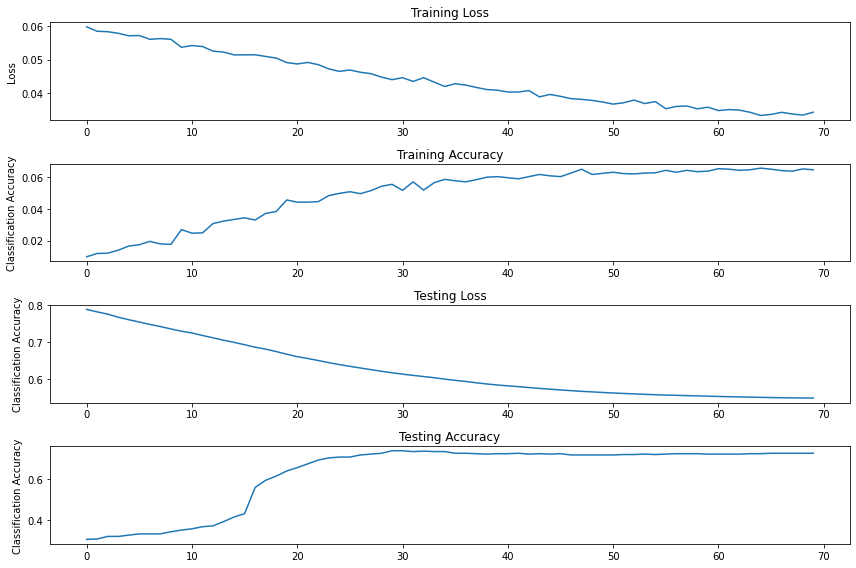

In [ ]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
# 1. log_lists 1
# - Min of Training Loss: 0.676791
# - Max of Training Accuracy: 0.580834
# - Mean of Training Loss: 0.930833
# - Mean of Training Accuracy: 0.549138

# - Max of Testing Accuracy: 0.758763
# - Mean of Testing Loss: 0.639751
# - Mean of Testing Accuracy: 0.741991

# 2. log_lists 2
# Min of Training Loss: 0.661804
# Max of Training Accuracy: 0.623923
# Mean of Training Loss: 0.675339
# Mean of Training Accuracy: 0.579164
# ----
# Max of Testing Accuracy: 0.754639
# Mean of Testing Loss: 0.647825
# Mean of Testing Accuracy: 0.663184

# 3. log_lists 3
# Min of Training Loss: 0.689231
# Max of Training Accuracy: 0.551534
# Mean of Training Loss: 0.691886
# Mean of Training Accuracy: 0.529895
# ----
# Max of Testing Accuracy: 0.769072
# Mean of Testing Loss: 0.672092
# Mean of Testing Accuracy: 0.727753

# 4. log_lists 4
# Min of Training Loss: 0.655381
# Max of Training Accuracy: 0.615822
# Mean of Training Loss: 0.668167
# Mean of Training Accuracy: 0.590891
# ----
# Max of Testing Accuracy: 0.760825
# Mean of Testing Loss: 0.602897
# Mean of Testing Accuracy: 0.751031

# 5. log_lists 5
# Min of Training Loss: 0.645203
# Max of Training Accuracy: 0.638573
# Mean of Training Loss: 0.664737
# Mean of Training Accuracy: 0.602872
# ----
# Max of Testing Accuracy: 0.773196
# Mean of Testing Loss: 0.595279
# Mean of Testing Accuracy: 0.755809

In [ ]:
pheme_thread_log_9.shape
pheme_thread_log_9.shape

(5802, 33)

In [ ]:
# pheme_thread_log_9

tensor_x1 = torch.Tensor(pheme_thread_log_8.values).unsqueeze(1)
tensor_y1 = torch.Tensor(pheme_y.values).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

tensor_x2 = torch.Tensor(ext_thread_log_8.values).unsqueeze(1)
tensor_y2 = torch.Tensor(ext_y.values).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 8
counts = np.bincount(pheme_y.values)
labels_weights = 1. / counts
weights = labels_weights[pheme_y.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print("Train X Size:", tensor_x1.shape, "/ Train y Size:", tensor_y1.shape)
print("Test X Size:", tensor_x2.shape, "/ Test y Size:", tensor_y2.shape)
print("Train Size",train_size,"Test Size",test_size)

In [ ]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)
# PATH = "./Model/state_dict_sparse_model.pt"

In [ ]:
train_acc, train_loss, val_acc, val_loss_list = train1(model=model_sparse, num_epochs=epochs,patience=5, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


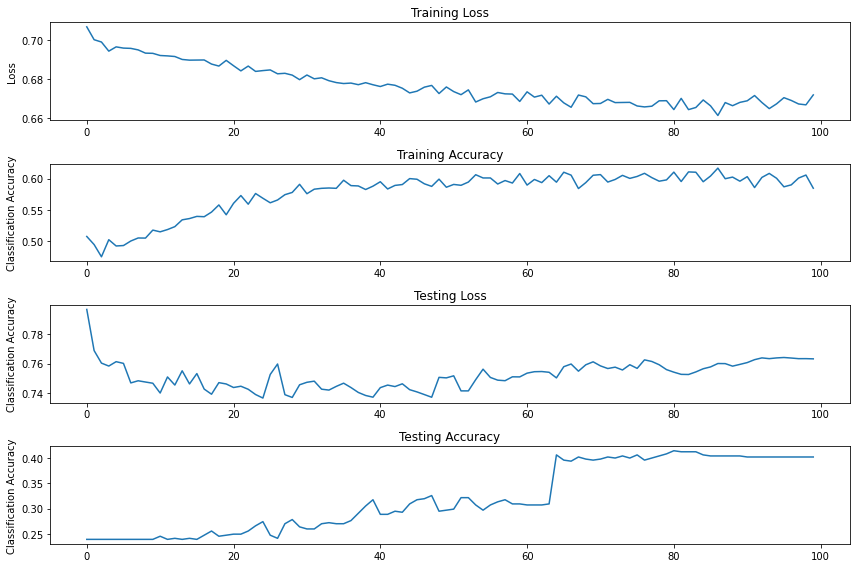

In [ ]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)